# Aligning PstI linkage map to scaffolds before ALLMAPS anchoring.

I will repeat here what I did with the SbfI and EcoRI map. After aligning the PstI markers from the map in Palomar et al to the genome, I will filter those tags and try to use the linkage map along with the PurgeHaplotigs results and the contig naming from FALCON-unzip to rescue as many multi alignments as possible. 

The PstI map contains markers from both forward and reverse reads. So I first need to take the read files and make a single fasta for alignment to the genome. 


In [3]:
import MISC_RAD_tools as MISC
from __future__ import division
from Bio.Blast import NCBIXML
from IPython.display import Image
from Bio import SeqIO
import gzip

In [151]:
print marker_IDs[:10]

['19807-66_bb', '19807-66_bb_r2', '35670-40_bb_r2', '19609-67_bb', '51711-24_bb', '9349-100_bb_r2', '5946-121_bb_r2', '5946-121_bb_r2', '9532-99_bb', '7734-109_bb_r2']


In [155]:
PstI_map_file = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Palomar_map_markers_and_blast/Female_palomar_map.txt"
R1_fasta = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Palomar_map_markers_and_blast/ForwardContigReference.fasta"
R2_fasta = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Palomar_map_markers_and_blast/ReverseContigsReference.fasta"

marker_IDs = []
for marker in open(PstI_map_file, 'r'):
    marker_IDs.append(marker.split()[0].rpartition("_")[0])

print len(marker_IDs)
print len(set(marker_IDs))

3596
2722


In [158]:
 
R1s = SeqIO.parse(open(R1_fasta, 'r'), 'fasta')
R2s = SeqIO.parse(open(R2_fasta, 'r'), 'fasta')

LM_marker_fasta = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Palomar_map_markers_and_blast/LM_markers.fasta", 'w')

R1_ids = []

for R1seq in R1s:
    
    R1_ids.append(R1seq.id)
    
    if R1seq.id in marker_IDs:
        SeqIO.write( R1seq, LM_marker_fasta, "fasta")

R2_ids = []       
for R2seq in R2s:
    
    R2_ids.append(R2seq.id)
    
    if R2seq.id in marker_IDs:
        SeqIO.write(R2seq, LM_marker_fasta,  "fasta")

LM_marker_fasta.close()

**Note** - Not all of the markers in the map are in the contig reference files. Not sure why . . . but I just can't do anything about it now. 

In [161]:
counter = 0
for marker in marker_IDs:
    if marker not in R1_ids and marker not in R2_ids:
        counter += 1
print counter, "markers not in the fasta files"

81 markers not in the fasta files


So the 3596 markers in the map fall onto 2722 RADtags, and as 81 of those don't have a sequence, that leaves me with 2696 marker sequences from the markers in the map. 


Ok, so I have aligned, using Blastn, all of the linkage mapped RADtags from Alan's map. The problem with mapping to this genome is that a lot of the tags will map to multiple places. So I want to filter the alignments for those that I know are correct, and then try to infer which alignments are correct for the markers which map to multiple places. 

There are two sources of noise that contribute to these messy alignments. 

1) This genome is very repetitive (Maybe 60% repeats or more).
2) This assembly extremely heterozygous (I estimate about 65% of the genome is present twice).

So a given tag is very likely to align to more than one position if it comes either from a region that is repetitive or represented by two scaffolds (haplotigs) in the assembly. However it is worth noting that the alignments should show quite different patterns in these two cases. If a RADtag falls inside a repeat, I would expect many alignments. If the reason for the multiple mappings is the heterozygosity of the genome, then I would expect only 2 decent alignments for that tag. 

Below, I will try to separate these two cases, and where possible, rescue the alignments by either finding the single best alignment, or confirming that the RADtag has aligned to haplotigs at the same physical position. 

## Initial alignment summary

There were 3596 markers in the PstI linkage map. These were aligned via blastn to the genome assembly (PacBio + Optical Mapping). 

First I just want to see how many alignments there were for each tag.

In [166]:
n_alignments = []

blastouts_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Palomar_map_markers_and_blast/PSTI_to_Rtemp.xml.gz"

N_records = 0

blast_outs_handle = gzip.open(blastouts_path, 'r')
blastouts = NCBIXML.parse(blast_outs_handle)

for record in blastouts:
    n_alignments.append(len(record.alignments))


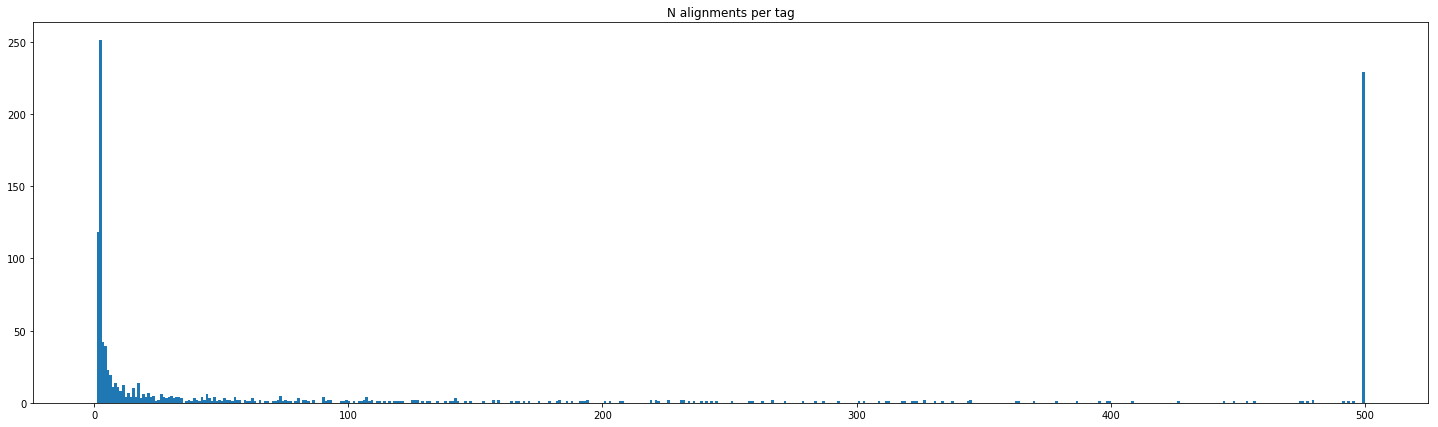

In [6]:
from matplotlib import pyplot as plt 
plt.figure(figsize = (25,7))
plt.hist(n_alignments, bins = 500)
plt.title("N alignments per tag")
plt.show()
    
#Co_alignments

I think there is a default maximum cut off of 500 alignments per marker in blastn - hence the large bar at the end of the plot. Nonetheless, this shows that many tags are in repetitive regions, and these are likely to be difficult to resolve, whatever we try.

But lets zoom in to the left of the plot to get a better view of whats going on there

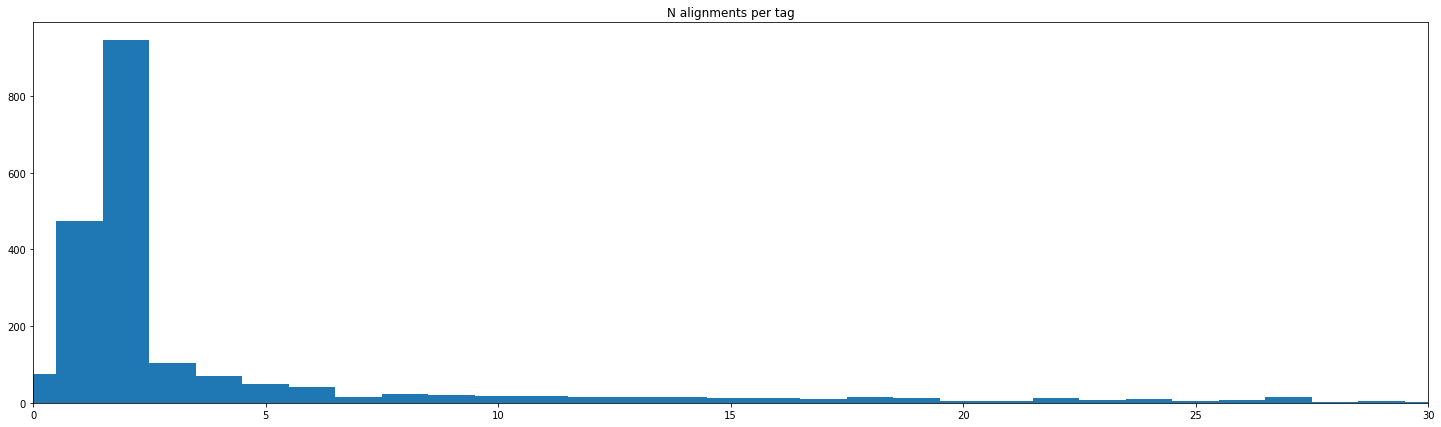

In [164]:
plt.figure(figsize = (25,7))
plt.hist(n_alignments, bins = 500, align="left")
plt.title("N alignments per tag")
plt.xlim(0,30)
plt.show()

So we can see here that there are quite a few tags that map just once, but more than double that map twice! This makes sense due to the heterozygous nature of the genome assembly and the fact that much of it is present in 2 copies. 

### Some preliminary filtering tests

So myself and colleagues have been aligning to this genome or earlier assemblies for a while, so I will first filter these alingments as we have done in papers in the past, i.e. the hit has to be good (evalue =< 1e-20) and the Evalue of the best hit must be at least 1e3* better than Evalue of the next best hit.

So note that we are looking for a single best hit for each marker!

In [167]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Palomar_map_markers_and_blast/PSTI_to_Rtemp.xml.gz"
Genome_fasta = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
best_hit_criteria = 1e-3
evalue_thresh = 1e-20
window = 1000
get_frags = 0
verb = 1

Kept_blast_records_1e3 = MISC.BlastParseExtra(blast_outs_path, Genome_fasta, best_hit_criteria, evalue_thresh, get_frags, window, 1)

Number of tags which aligned at least once: 2622
Number of multi-alignments kept: 655
Number of unique alignments kept: 465
Number of multi-alignments removed: 1493
Number of unique alignments removed: 9


So, all of the 1122 markers aligned. However only 5879 (~51%) were retained. 

The 542 (~49%) which were removed were filtered because they mapped to more than one place with no "best hit". 

So over half of the alignments were exluded because they mapped to multiple places but there was not an obvious best hit. So I want to take a look into these alignments. Specifically because, in this case, we know there is a lot of heterozygosity in the assembly, so there are likely to be markers which hit both scaffolds of the same position and it would make sense that both alignments would be good, and so there is no "best hit". 



## Rescuing Two-hit and Multi-hit alignments

So we know that the assembly heterozygosity here is an issue. The good news is that this is a very different problem to the multi-alignments coming from repetitive sequence because we know the alignments are at the same place in the genome. So we can potentially still use these alignments and in doing so, anchor more of the genome assembly.

So below I want to get a really good idea of what is happening to all my alignments. So below I have modified my usual blast filter function to track what happens to all alignments, including those which either hit ONLY two scaffolds or which hit more than two but have a clear "best two" alignments (without a significantly "best" hit between them). 


In [169]:
from Bio.Blast import NCBIXML

evalue_thresh = 1e-20
best_hit_criteria = 1e-3

Co_alignments = {}
no_hit = 0
unique = 0
unique_removed = 0
best_from_two_only = 0
two_only_removed = 0
Best_multi = 0
multi_removed = 0
Two_best_multi = 0

N_records = 0

blast_outs_handle = gzip.open(blast_outs_path, 'r')
blastouts = NCBIXML.parse(blast_outs_handle)

for record in blastouts:
    
    if len(record.alignments) == 0:
        no_hit += 1
    
    elif len(record.alignments) == 1:  ## If there's only one hit
        if record.alignments[0].hsps[0].expect <= evalue_thresh:  ## And if that hit meets the e-value cutoff
            unique += 1
        else:
            unique_removed += 1
        
    elif len(record.alignments) == 2:  ## If there's only two hits 
        if all([record.alignments[0].hsps[0].expect <= evalue_thresh, ## If the first meets e-value cuttoff
                record.alignments[0].hsps[0].expect < best_hit_criteria * record.alignments[1].hsps[0].expect]): ## and if the first alignmnet has an eval lower than 1e-5 * the eval of the second alignment
            best_from_two_only += 1
        else:
            two_only_removed += 1


    elif len(record.alignments) >= 3:  ## If there are 3 or more hits
        if all([record.alignments[0].hsps[0].expect <= evalue_thresh,  ## if the first meets e-value cuttoff
                record.alignments[0].hsps[0].expect < best_hit_criteria * record.alignments[1].hsps[0].expect]): ## and if the first alignmnet has an eval lower than 1e-5 * the eval of the second alignment.
            Best_multi += 1

        elif all([all([record.alignments[0].hsps[0].expect <= evalue_thresh, ## if the first meets e-value cuttoff
                       record.alignments[1].hsps[0].expect <= evalue_thresh, ## if the second also meets e-value cuttoff
                       record.alignments[1].hsps[0].expect < best_hit_criteria * record.alignments[2].hsps[0].expect])]): ## and if the 2 alignment has an eval lower than 1e-5 * the eval of the third alignment
            Two_best_multi += 1
            
            key_1 = "%s %s" % (record.alignments[0].hit_def, record.alignments[1].hit_def)
            key_2 = "%s %s" % (record.alignments[1].hit_def, record.alignments[0].hit_def)
    
            if key_1 in Co_alignments:
                Co_alignments[key_1].append(record.query)
            elif key_2 in Co_alignments:
                Co_alignments[key_2].append(record.query)
            else:
                Co_alignments[key_1] = [record.query]
        else:
            multi_removed += 1
    


    N_records += 1

print "N_tags aligned at least once = ", (unique+unique_removed+best_from_two_only+two_only_removed+Best_multi+Two_best_multi+multi_removed)
print "N_tags with no hits = ", no_hit
print "Unique = ", unique
print "Unique but removed = ", unique_removed
print "Best hit from only two = ", best_from_two_only
print "Only two hits removed = ", two_only_removed
print "Best single hit from multi = ", Best_multi
print "Best two hits from multi = ", Two_best_multi
print "Multi hits removed = ", multi_removed

print "Total = ", (no_hit+unique+unique_removed+Best_multi+Two_best_multi+multi_removed)
    
#Co_alignments


N_tags aligned at least once =  2622
N_tags with no hits =  74
Unique =  465
Unique but removed =  9
Best hit from only two =  201
Only two hits removed =  744
Best single hit from multi =  454
Best two hits from multi =  422
Multi hits removed =  327
Total =  1751


Lets visualise this in a pie chart to help keep track of things

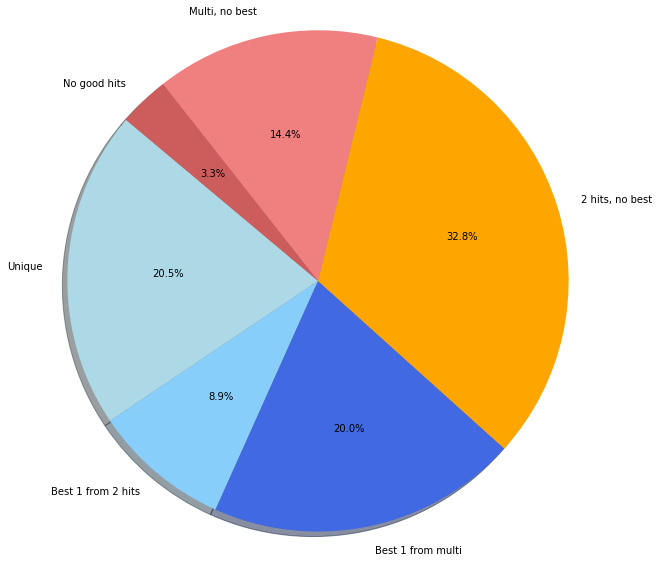

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
# Data to plot
labels = ['Unique', 'Best 1 from 2 hits', "Best 1 from multi", '2 hits, no best',  'Multi, no best ', 'No good hits']
sizes = [465, 201, 454, 744, 327, 74]
colors = ['lightblue', 'lightskyblue', "royalblue", "orange", 'lightcoral', 'indianred']
explode = (0, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, )

plt.axis('equal')
plt.show()

So anything in blue here is usable already i.e. markers with a single good alignment (unique) or a clear best alignment from 2 or more hits ('Best 1 from 2 hits', "Best 1 from multi").

Anything in Red is not rescuable as there is no one or two clear winners. 

Things in Orange are **potentially rescuable**. The reason is that we expect many markers to be able to map to two places due to heterozygosity. In this case both alignments are correct and it is not necassary to choose one (unlike in a multi mapping where markers are aligning to repeats which have different physical positions in the genome). 
 
So we can try to validate these "2 hits, no best" alignments by seeing if markers adjacent to eachother on the linkage map, align to the same 2 scaffolds. 



## General strategy / workflow

Below is a schematic of the workflow I will try to use to assess if each alignment can be retained in the final dataset for ALLMAPS. As you will see, it is pretty complicated, but I will try to stick to it and refer back as much as possible in the notebook below (i've added codes to various points to help with this). If some of the descriptions are vague I'll describe them more carefully when I get to them.

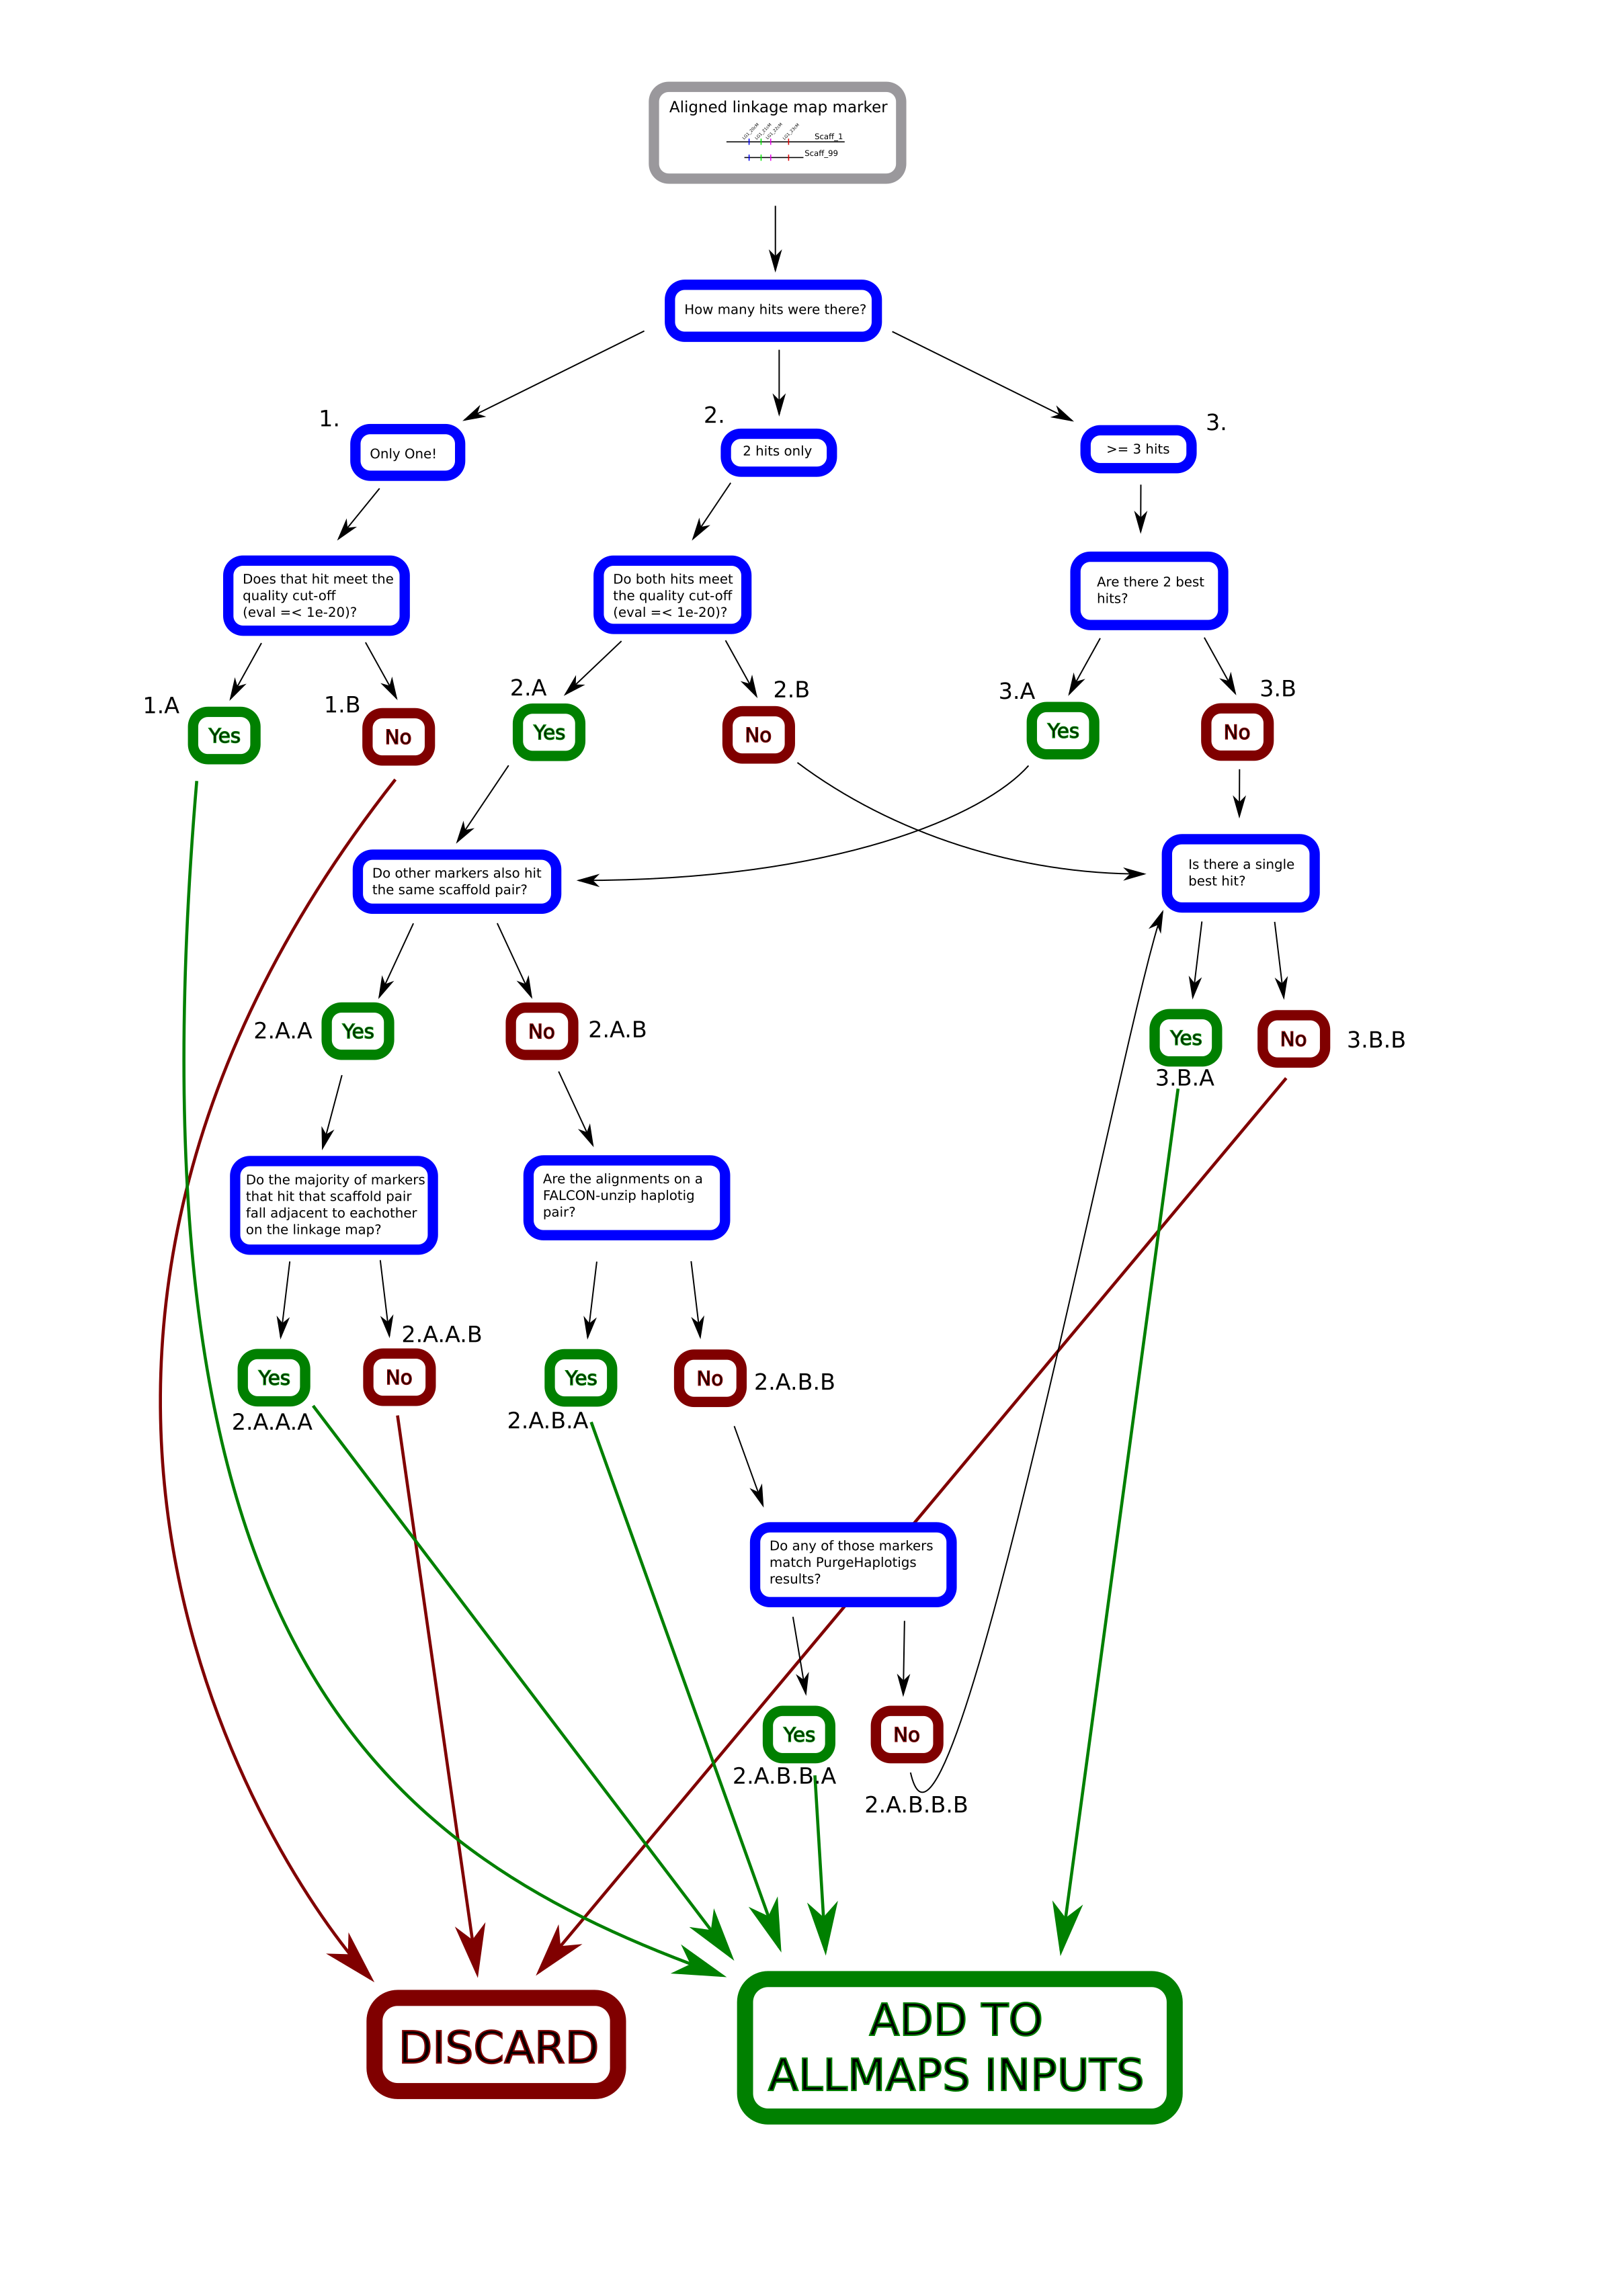

In [298]:
Image("/home/djeffrie/Data/Genomes/Rtemp_hybrid/GitHub_repo/figures/LM_marker_alignment/LM_marker_alignment_filtering_schematic.png")

## Finding markers with only one hit!

Lets start with the easy one. Path 1 in the workflow. We are looking for markers with a single alignment only. If we find this, we test whether the hit has an evalue of < 1e-20. If so, then we keep the alignment for the ALLMAPS inputs. 

** We start with an important step, making the dictionary for the records to keep for ALLMAPS. **

We will add to this as we perform other tests below. 

In [171]:
Ready_for_ALLMAPS_1A = {}

evalue_thresh = 1e-20
best_hit_criteria = 1e-3

N_records = 0
no_hit = 0
single_good_hit = 0
more_than_one_hit = 0


blast_outs_handle = gzip.open(blast_outs_path, 'r')
blastouts = NCBIXML.parse(blast_outs_handle)

for record in blastouts:
    N_records += 1
    if len(record.alignments) == 0:
        no_hit += 1
    
    elif len(record.alignments) == 1:  ## If there's only one hit
        
        if record.alignments[0].hsps[0].expect <= evalue_thresh:  ## And if that hit meets the e-value cutoff
            
            single_good_hit += 1
            
            Ready_for_ALLMAPS_1A[record.query] = {}
            Ready_for_ALLMAPS_1A[record.query]["hit_ID"] = record.alignments[0].hit_def
            Ready_for_ALLMAPS_1A[record.query]["hit_STRT"] = record.alignments[0].hsps[0].sbjct_start
            Ready_for_ALLMAPS_1A[record.query]["evalue"] = record.alignments[0].hsps[0].expect
            Ready_for_ALLMAPS_1A[record.query]["code"] = "1A"

        else:
            no_hit += 1
            
    elif len(record.alignments) > 1:
        more_than_one_hit += 1
        
        
print "N queries processed = %s " % N_records
print "N queries with no good hit = %s " % no_hit
print "N queries with a single good hit = %s " % single_good_hit
print "N_queries with more than one hit = %s " % more_than_one_hit

N queries processed = 2696 
N queries with no good hit = 83 
N queries with a single good hit = 465 
N_queries with more than one hit = 2148 


## Finding two-hit alignments

Next we will look at the alignments that have more than 2 hits. Somewhat counterintuitively, we will begin by searching for the markers with 2 hits that are better than the rest. This may include markers where the first alignment is better than the second, but that doesn't mean that the second isn't the haplotig. If I was to search first for markers with a single best hit, I would be potentially loosing a lot of information about haplotigs from the alignments. Obviously I want to keep this, not just for the anchoring but in general for finding haplotigs in the assembly. 


First get the linkage map info

In [189]:
## Function to get the information from the linkage map

LM_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Palomar_map_markers_and_blast/Female_palomar_map.txt"

LM = open(LM_path, 'r').readlines()

PstI_linkage_map_dict = {}
    
print "There are %s markers in the linkage map" % len(LM)

for tag in LM:
    if "_" in tag:
        tag_ID = tag.split()[0].rpartition("_")[0]
    else:
        tag_ID = tag.split()[0]
    LG = tag.split()[1]
    POS = tag.split()[2]
    
    PstI_linkage_map_dict[tag_ID] = {}
    PstI_linkage_map_dict[tag_ID]["LG"] = LG
    PstI_linkage_map_dict[tag_ID]["POS"] = POS
     


There are 3596 markers in the linkage map


In [191]:
len(PstI_linkage_map_dict)

2772

Now define a function (modified from the usual BlastParser) to specifically find alignments which are likely due to haplotigs. I will output these alignments in a dictionary. I will also output all other alignments in a separate dictionary to be passed to other parts of the workflow in the schamatic above. The tests performed here are:

- Are there only TWO or THREE OR MORE hits?
    - If ONLY TWO, are they both high quality alignments (i.e. **2.A in workflow**)?
    - If THREE OR MORE, are there TWO BEST HITS (**3.A in workflow**)?
    
If the answer to the above tests is YES, then they will be retained for assessment against the linkage map (following path 2 in the workflow). 

If the answer to the above tests is NO, they will be passed down path 3, to search for a single best hit.
    


In [194]:
def LM_haplotig_finder_PstI(blastouts_path):

    
    from Bio.Blast import NCBIXML
    import gzip

    evalue_thresh = 1e-20
    best_hit_criteria = 1e-3

    Putative_haplotigs = {}
    
    ## counters
    
    no_hit = 0
    single_hit = 0
    two_hits_only = 0
    multi_hit = 0
    
    two_good_hits = 0
    two_only_removed = 0
    multi_removed = 0
    Two_best_multi = 0

    N_records = 0

    if blastouts_path.endswith("gz"):
        blast_outs_handle = gzip.open(blastouts_path, 'r')
    else:
        blast_outs_handle = open(blastouts_path, 'r')
    
    blastouts = NCBIXML.parse(blast_outs_handle)

    for record in blastouts:
        
        N_records += 1
        query = record.query
        
       
        if query in PstI_linkage_map_dict:

            if len(record.alignments) == 0:
                no_hit += 1

            elif len(record.alignments) == 1:  ## If there's only one hit
                single_hit += 1

            elif len(record.alignments) == 2:  ## If there's only two hits 

                two_hits_only += 1

                if all([record.alignments[0].hsps[0].expect <= evalue_thresh, ## If the first meets e-value cuttoff
                        record.alignments[1].hsps[0].expect <= evalue_thresh]): ## If the second meets e-value cuttoff

                    two_good_hits += 1

                    Putative_haplotigs[query] = {}

                    Putative_haplotigs[query][record.alignments[0].hit_def] = {}
                    Putative_haplotigs[query][record.alignments[0].hit_def]["Evalue"] = record.alignments[0].hsps[0].expect
                    Putative_haplotigs[query][record.alignments[0].hit_def]["START"] = record.alignments[0].hsps[0].sbjct_start

                    Putative_haplotigs[query][record.alignments[1].hit_def] = {}
                    Putative_haplotigs[query][record.alignments[1].hit_def]["Evalue"] = record.alignments[1].hsps[0].expect
                    Putative_haplotigs[query][record.alignments[1].hit_def]["START"] = record.alignments[1].hsps[0].sbjct_start


                else:
                    two_only_removed += 1


            elif len(record.alignments) >= 3:  ## If there are 3 or more hits

                multi_hit += 1

                if all([record.alignments[0].hsps[0].expect <= evalue_thresh, ## if the first meets e-value cuttoff
                        record.alignments[1].hsps[0].expect <= evalue_thresh, ## if the second also meets e-value cuttoff
                        record.alignments[1].hsps[0].expect < best_hit_criteria * record.alignments[2].hsps[0].expect]): ## and if the 2 alignment has an eval lower than 1e-5 * the eval of the third alignment

                    Two_best_multi += 1

                    Putative_haplotigs[query] = {}

                    Putative_haplotigs[query][record.alignments[0].hit_def] = {}
                    Putative_haplotigs[query][record.alignments[0].hit_def]["Evalue"] = record.alignments[0].hsps[0].expect
                    Putative_haplotigs[query][record.alignments[0].hit_def]["START"] = record.alignments[0].hsps[0].sbjct_start

                    Putative_haplotigs[query][record.alignments[1].hit_def] = {}
                    Putative_haplotigs[query][record.alignments[1].hit_def]["Evalue"] = record.alignments[1].hsps[0].expect
                    Putative_haplotigs[query][record.alignments[1].hit_def]["START"] = record.alignments[1].hsps[0].sbjct_start


                else:
                    multi_removed += 1



    print "Number of queried markers = ", N_records
    
    print "\nN_tags aligned at least once = ", (single_hit + two_hits_only + multi_hit) 
    print "N_tags with no hits = ", no_hit
    print "N_tags with a single hit = ", single_hit
    
    print "\nN_tags with only 2 hits = ", two_hits_only
    print "N_tags with 2 good hits = ", two_good_hits
    print "N_tags with 2 hits not kept = ", two_only_removed
    
    print "\nN_tags with >2 hits = ", multi_hit
    print "N_tags with >2 hits with 2 best hits = ", Two_best_multi
    print "N_tags with >2 hits without 2 best hits = ", multi_removed

    print "\nTotal alignments processed = ", (no_hit+ single_hit + two_hits_only + multi_hit)

    print "\nTotal putative haplotigs = ", (two_good_hits + Two_best_multi)
    
    return(Putative_haplotigs)


Apply that function to our Blastn results. This will give me a dictionary where marker names are keys, and the two scaffolds they align to are the values (along with the evalue and alignment coordinate).

In [195]:
Put_haplotigs = LM_haplotig_finder_PstI(blast_outs_path)

Number of queried markers =  2696

N_tags aligned at least once =  2622
N_tags with no hits =  74
N_tags with a single hit =  474

N_tags with only 2 hits =  945
N_tags with 2 good hits =  893
N_tags with 2 hits not kept =  52

N_tags with >2 hits =  1203
N_tags with >2 hits with 2 best hits =  528
N_tags with >2 hits without 2 best hits =  675

Total alignments processed =  2696

Total putative haplotigs =  1421


### Ok, so we are now at 2.A on my workflow schematic.

We have our dictionary of putatitive haplotig-pair alignments. However we want to somehow validate these. The easiest and most reliable way to do that is to ask, are there scaffold pairs where more than one tag aligns to both of them. And if so, are those tags adjacent to eachother in the linkage map?

So help with that, I will make a some more dictionaries, organised by scaffold pair, where the value is a list of the tags supporting each pair. 

- The ``scaffold_pairs`` dictionary will have all alignemnts in.
- The ``scaffold_pairs_2_A_A`` dictionary will have only those with more than one marker hitting the same pair
- The ``scaffold_pairs_2_A_B`` dictionary will have those pairs where only one marker hits them. 

In [196]:
scaffold_pairs = {}

for marker in Put_haplotigs:
    
    scaff_1 = Put_haplotigs[marker].keys()[0]
    scaff_2 = Put_haplotigs[marker].keys()[1]

    if not any([" ".join([scaff_1, scaff_2]) in scaffold_pairs, " ".join([scaff_2, scaff_1]) in scaffold_pairs]):
        scaffold_pairs[" ".join([scaff_1, scaff_2])] = []
        scaffold_pairs[" ".join([scaff_1, scaff_2])].append(marker)
        
    elif " ".join([scaff_1, scaff_2]) in scaffold_pairs:
        scaffold_pairs[" ".join([scaff_1, scaff_2])].append(marker)
        
    elif " ".join([scaff_2, scaff_1]) in scaffold_pairs:
        scaffold_pairs[" ".join([scaff_2, scaff_1])].append(marker)
        

## Now add to either 2_A_A or 2_A_B
        
scaffold_pairs_2_A_A = {}
scaffold_pairs_2_A_B = {}

for pair in scaffold_pairs:
    if len(scaffold_pairs[pair]) > 1:
        
        scaffold_pairs_2_A_A[pair] = scaffold_pairs[pair]
        
    elif len(scaffold_pairs[pair]) == 1:
        scaffold_pairs_2_A_B[pair] = scaffold_pairs[pair]
        
        
    else:
        print len(scaffold_pairs[pair])
    
print "N scaffold pairs supported by more than one aligned RADtag = ", len(scaffold_pairs_2_A_A)
print "N scaffold pairs supported by one aligned RADtag = ", len(scaffold_pairs_2_A_B)

if  (len(scaffold_pairs_2_A_A)+len(scaffold_pairs_2_A_B)) == len(scaffold_pairs):
    print "All scaffold pairs processed"
else:
    print "Not all scaffolds caught"
    print (len(scaffold_pairs_2_A_A)+len(scaffold_pairs_2_A_B)), len(scaffold_pairs)
    

N scaffold pairs supported by more than one aligned RADtag =  239
N scaffold pairs supported by one aligned RADtag =  874
All scaffold pairs processed


Just check there is no overlap in tags between the 2AA and 2AB pairs. 

In [197]:
for pair1 in scaffold_pairs_2_A_B:
    for pair2 in scaffold_pairs_2_A_A:
        if scaffold_pairs_2_A_B[pair1][0] in scaffold_pairs_2_A_A[pair2]:
            print "yes"        

Looks good. So 239 pairs (i.e. 478 scaffolds) are mapped to by more than one tag. These tags are at **2.A.A** on our workflow.

The markers in the **2.A.B** scaffold pair dictionary will be processed later on

Now I can look at those scaffolds and see if the markers are adjacent to eachother on the linkage map. 

In [199]:
Passed_scaffold_pairs_2_A_A_A = {}
Failed_scaffold_pairs_2_A_A_B = {}

for pair in scaffold_pairs_2_A_A:
    if len(scaffold_pairs_2_A_A[pair]) >= 2:
        LGs = []
        for locus in scaffold_pairs_2_A_A[pair]:
            #print locus
            locus_LG = PstI_linkage_map_dict[locus]["LG"]
            LGs.append(locus_LG)
        if len(set(LGs)) == 1:
            Passed_scaffold_pairs_2_A_A_A[pair] = scaffold_pairs_2_A_A[pair]
        else:
            Failed_scaffold_pairs_2_A_A_B[pair] = scaffold_pairs_2_A_A[pair]

In [200]:
print len(Passed_scaffold_pairs_2_A_A_A), "scaffolds passed"
print len(Failed_scaffold_pairs_2_A_A_B), "scaffolds failed"

236 scaffolds passed
3 scaffolds failed


In [201]:
Failed_scaffold_pairs_2_A_A_B

{u'Super-Scaffold_2263 Super-Scaffold_827': [u'13768-82_bb_r2',
  u'13768-82_bb',
  u'28133-51_bb',
  u'9082-101_bb'],
 u'Super-Scaffold_3631 Super-Scaffold_797': [u'28307-51_bb',
  u'28307-51_bb_r2',
  u'19779-66_bb'],
 u'Super-Scaffold_3797 Super-Scaffold_2178': [u'20959-64_bb', u'6430-118_bb']}

So thats a pretty good pass rate! But here we require that we keep only scaffolds where EVERY tag belongs to the correct linkage group. Can we rescue any of the 3?

In [203]:
for i in scaffold_pairs['Super-Scaffold_2263 Super-Scaffold_827']:
    print pair, PstI_linkage_map_dict[i]

 Super-Scaffold_3654 Super-Scaffold_2599 {'LG': 'Rt3', 'POS': '276.8'}
Super-Scaffold_3654 Super-Scaffold_2599 {'LG': 'Rt3', 'POS': '276.8'}
Super-Scaffold_3654 Super-Scaffold_2599 {'LG': 'Rt3', 'POS': '276.17'}
Super-Scaffold_3654 Super-Scaffold_2599 {'LG': 'Rt5', 'POS': '194.668'}


This pair clearly belongs to LG Rt3. So I can just add it to the Passed scaffolds list.

In [205]:
from collections import Counter

for pair in Failed_scaffold_pairs_2_A_A_B:
    
    if len(scaffold_pairs[pair]) > 2:
        
        loci = scaffold_pairs[pair]
        LGs = []
        
        for i in loci:
            LGs.append(PstI_linkage_map_dict[i]["LG"])
                       
        counted = Counter(LGs)
        real_LG = max(LGs, key=counted.get)
        
        for i in loci:
            if PstI_linkage_map_dict[i]["LG"] != real_LG:
                
                print "Tag %s mis-aligned and so removed" % i
                
                del PstI_linkage_map_dict[i]  ## remove from the map dictionary
                scaffold_pairs[pair].remove(i) ## remove from scaffold co-alignment dictionary
                
        Passed_scaffold_pairs_2_A_A_A[pair] = scaffold_pairs[pair]

Tag 19779-66_bb mis-aligned and so removed
Tag 9082-101_bb mis-aligned and so removed


So I could rescue 2 (i.e. the two that had >2 tags mapping to them). Now lets just check that previous example again, to make sure this worked properly

In [206]:
for i in scaffold_pairs['Super-Scaffold_2263 Super-Scaffold_827']:
    print pair, PstI_linkage_map_dict[i]

Super-Scaffold_3797 Super-Scaffold_2178 {'LG': 'Rt3', 'POS': '276.8'}
Super-Scaffold_3797 Super-Scaffold_2178 {'LG': 'Rt3', 'POS': '276.8'}
Super-Scaffold_3797 Super-Scaffold_2178 {'LG': 'Rt3', 'POS': '276.17'}


Yep, all good. So how many scaffolds can I retain by including these in the analyses?

In [207]:
print "%s scaffold pairs" % str(len(Passed_scaffold_pairs_2_A_A_A))

238 scaffold pairs


i.e. 476 scaffolds which would otherwise have been thrown out. **These alignments are at 2.A.A.A on the workflow** and are ready to go into the ALLMAPS inputs. However I need to decide which scaffold of the pair to keep and which to set aside as the "haplotig". I will keep the contig with the highest number of tags mapping to it and if that is equal, then I will take the longest one. I will then set aside the alternative contig with some information relating to its parent contig and its position in that contig. 

To do the above, I will first make a dictionary containing all the relevent info for each scaffold (i.e. # hits, length). I will then go through the tags which map to the scaffold pairs above, and add them to the "Ready_for_ALLMAPS" pool, along with the hit information for the retained contig only. 

**Note, I will need to go back through the markers already in the "Ready_for_ALLMAPS" dictionary, and remove any which hit those contigs/scaffolds which I will set aside, as this will just confuse ALLMAPS down the line. 

In [208]:
### Getting scaffold length info. 

Genome_fasta = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Assembly/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"

scaffold_lengths = {}

for scaff in SeqIO.parse(open(Genome_fasta, 'r'), "fasta"):
    scaffold_lengths[scaff.id] = len(scaff.seq)


In [209]:
## getting the number of hits per scaffold

## This is the number of markers which hit 2 places, plus the number of markers that hit only 1. 

scaffold_info_dict = {}

for pair in Passed_scaffold_pairs_2_A_A_A:
    scaff_1 = pair.split()[0]
    scaff_2 = pair.split()[1]
    
    scaffold_info_dict[scaff_1] = {}
    scaffold_info_dict[scaff_1]["N_hits"] = []
    
    scaffold_info_dict[scaff_2] = {}
    scaffold_info_dict[scaff_2]["N_hits"] = []

for marker in Put_haplotigs:
    for hit in Put_haplotigs[marker]:
        if hit in scaffold_info_dict:
            scaffold_info_dict[hit]["N_hits"].append(marker)
    
    
    

#### I will add the single hit markers separately to see how often a pair with markers which match to an alternative contig are also hit by a marker which hits only one of the pair. 

In [210]:
import copy  ## note that deep copy is the only way of duplicating dictionaries and making the duplicate editable separately. Otherwise the will just be two names that point to the same object.
scaff_info_2 = copy.deepcopy(scaffold_info_dict)

In [211]:
for marker in Ready_for_ALLMAPS_1A:
    hit_ID = Ready_for_ALLMAPS_1A[marker]["hit_ID"]
    
    if hit_ID in scaff_info_2:
        scaff_info_2[hit_ID]["N_hits"].append(marker)



In [212]:
count = 0

for scaffold in scaff_info_2:
    if len(scaff_info_2[scaffold]["N_hits"]) - len(scaffold_info_dict[scaffold]["N_hits"]) > 0:
        count += 1
        
print "Number of scaffolds (from the haplotig pairs) also hit by a single-hit marker =", count

Number of scaffolds (from the haplotig pairs) also hit by a single-hit marker = 70


So now I have my scaffold information in a readily accessible dictionary, I can make decisions about which contigs/scaffolds to keep (refferred to as "Primary contigs") and which to set aside ("Alternative contigs")

In [213]:
primary_contigs = {}
alternative_contigs = {}

for pair in Passed_scaffold_pairs_2_A_A_A:
    scaff_1 = pair.split()[0]
    scaff_2 = pair.split()[1]

    if  len(scaff_info_2[scaff_1]["N_hits"]) > len(scaff_info_2[scaff_2]["N_hits"]):
        primary_contigs[scaff_1] = {}
        primary_contigs[scaff_1]["ALT"] = scaff_2
        
        alternative_contigs[scaff_2] = {}
        alternative_contigs[scaff_2]["PRIM"] = scaff_1
        
        
    elif  len(scaff_info_2[scaff_1]["N_hits"]) < len(scaff_info_2[scaff_2]["N_hits"]):
        primary_contigs[scaff_2] = {}
        primary_contigs[scaff_2]["ALT"] = scaff_1
        
        alternative_contigs[scaff_1] = {}
        alternative_contigs[scaff_1]["PRIM"] = scaff_2
        
    elif  len(scaff_info_2[scaff_1]["N_hits"]) == len(scaff_info_2[scaff_2]["N_hits"]):
        ## check lengths
        
        if scaffold_lengths[scaff_1] > scaffold_lengths[scaff_2]:
            primary_contigs[scaff_1] = {}
            primary_contigs[scaff_1]["ALT"] = scaff_2
            
            alternative_contigs[scaff_2] = {}
            alternative_contigs[scaff_2]["PRIM"] = scaff_1
        
        elif scaffold_lengths[scaff_1] < scaffold_lengths[scaff_2]:
            primary_contigs[scaff_2] = {}
            primary_contigs[scaff_2]["ALT"] = scaff_1
        
            alternative_contigs[scaff_1] = {}
            alternative_contigs[scaff_1]["PRIM"] = scaff_2
        
        else:
            print "Not captured"
    else:
        print "not captured"

Ok! So now I have a list of primary contigs, with their partner recorded, and the same for the alternatives. The primaries can now go in the "Ready for ALLMAPS" dictionary. 

First, I will remove the single-hit markers (**1.A**) which hit alternative contigs

In [214]:
print "Before removing single-hit markers which align to 'ALTERNATIVE' contigs there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A)

Before removing single-hit markers which align to 'ALTERNATIVE' contigs there were 465 markers in the ALLMAPS input


In [215]:
Ready_for_ALLMAPS_1A_2AAA = {}

for marker in Ready_for_ALLMAPS_1A:
    if Ready_for_ALLMAPS_1A[marker]["hit_ID"] not in alternative_contigs:
        
        Ready_for_ALLMAPS_1A_2AAA[marker] = Ready_for_ALLMAPS_1A[marker]
        

In [216]:
print "After removing single-hit markers which align to 'ALTERNATIVE' contigs there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA)

After removing single-hit markers which align to 'ALTERNATIVE' contigs there were 455 markers in the ALLMAPS input


Now I will add the alignments to the PRIMARY contigs for those tags where there were 2 or more good alignments confirmed to be haplotigs by the linkage map. 

In [217]:
for pair in Passed_scaffold_pairs_2_A_A_A:
    for marker in Passed_scaffold_pairs_2_A_A_A[pair]:
        for hit in Put_haplotigs[marker]:
            if hit in primary_contigs:
                Ready_for_ALLMAPS_1A_2AAA[marker] = {}
                Ready_for_ALLMAPS_1A_2AAA[marker]['hit_ID'] = hit
                Ready_for_ALLMAPS_1A_2AAA[marker]['hit_STRT'] = Put_haplotigs[marker][hit]['START']
                Ready_for_ALLMAPS_1A_2AAA[marker]['evalue'] = Put_haplotigs[marker][hit]['Evalue']
                Ready_for_ALLMAPS_1A_2AAA[marker]['ALT_contig'] = primary_contigs[hit]["ALT"]
                Ready_for_ALLMAPS_1A_2AAA[marker]["code"] = "2AAA"

In [218]:
print "After adding multi-hit marker alignments to 'PRIMARY' contigs (2.A.A.A) there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA)

After adding multi-hit marker alignments to 'PRIMARY' contigs (2.A.A.A) there were 998 markers in the ALLMAPS input


## 2.A.B. Markers which hit 2 scaffolds, but with no other markers supporting that pair

So now I want to try to rescue the alignments where a tag maps to two scaffolds with good alignment score, but where no other tag maps to the same pair. I have a feeling, based on the relative accuracy of alignemnts dealt with so far, that many of these pairs will be true haplotigs. However we can'g just go on feelings here. So I think there are a couple of things I can do to rescue these:

1. During assembly, FALCON-unzip knowingly creates haplotigs when it can't find a single path through a bubble. When it does this, it names the haplotig it creates according to the primary contig. For example contig 000123F-010-01 is a haplotig of primary contig 000123F. So one thing I can do is simply look through all the un-confirmed pairs and accept those which follow this naming convention. 

2. PurgeHaplotigs has been run and will independently find haplotigs based on read coverage and then alignments. So I can cross-check the mapped scaffold pairs against the outputs of this analyses.


## Looking for Falcon haplotigs in linkage mapped scaffold pairs

In [66]:
scaffold_pairs_2_A_B

{u'000026F-001-01|quiver_obj Super-Scaffold_496': [u'2996307'],
 u'000044F-004-01|quiver_obj Super-Scaffold_150': [u'2291547'],
 u'000044F-010-01|quiver_obj Super-Scaffold_150': [u'73622'],
 u'000053F-006-01|quiver_obj Super-Scaffold_878': [u'544149'],
 u'000056F-002-01|quiver_obj Super-Scaffold_812': [u'1774068'],
 u'000061F-001-01|quiver_obj Super-Scaffold_3204': [u'403765'],
 u'000091F-004-01|quiver_obj Super-Scaffold_1093': [u'268379'],
 u'000105F-004-01|quiver_obj Super-Scaffold_1073': [u'923349'],
 u'000134F-001-01|quiver_obj Super-Scaffold_49': [u'225115'],
 u'000175F-007-01|quiver_obj Super-Scaffold_568': [u'1708885'],
 u'000180F-007-01|quiver_obj Super-Scaffold_539': [u'1227985'],
 u'000196F-005-01|quiver_obj Super-Scaffold_96': [u'264987'],
 u'000322F-004-01|quiver_obj Super-Scaffold_3552': [u'187577'],
 u'000332F-002-01|quiver_obj Super-Scaffold_509': [u'532662'],
 u'000435F-002-01|quiver_obj Super-Scaffold_2000009192': [u'523814'],
 u'000441F-005-01|quiver_obj Super-Scaffol

In [219]:
scaffold_pairs_2_A_B_kept = {}

for pair in scaffold_pairs_2_A_B:
    scaff_1 = pair.split()[0]
    scaff_2 = pair.split()[1]
    
    if "quiver" in scaff_1:
        scaff_1 = scaff_1.split("|")[0]
    if "quiver" in scaff_2:
        scaff_2 = scaff_2.split("|")[0]
        
    if "-" in scaff_1:
        if scaff_1.split("-")[0] == scaff_2:
            scaffold_pairs_2_A_B_kept[pair] = scaffold_pairs_2_A_B[pair]
    elif "-" in scaff_2:
        if scaff_2.split("-")[0] == scaff_1:
            scaffold_pairs_2_A_B_kept[pair] = scaffold_pairs_2_A_B[pair]
            
scaffold_pairs_2_A_B_kept

{u'003454F-004-01|quiver_obj 003454F|quiver_subseq_256645:288050_obj': [u'5367-126_bb'],
 u'004037F-002-01|quiver_obj 004037F|quiver_obj': [u'14271-81_bb_r2'],
 u'012993F|quiver_obj 012993F-001-01|quiver_obj': [u'26148-54_bb'],
 u'017138F|quiver_obj 017138F-001-01|quiver_obj': [u'23717-59_bb_r2']}

Ok, so there are 4 of these. However, I think that there should be some more matches between mappings onto FALCON associated contigs.  I think the reason I don't see them is that these contigs have been included in scaffolds and so given a different name. So In the assembly these contigs will have been renamed as Super-scaffold_\*. However I can find the name of the original contig using the .agp file, which describes how contigs fit into scaffolds, gaps etc. 

So below I will use this .agp file to convert the mapping hits into their contig names, rather than their scaffold names. 

The file looks like this:

```
Obj_Name      Obj_Start       Obj_End PartNum Compnt_Type     CompntId_GapLength      CompntStart_GapType     CompntEnd_Linkage       Orientation_LinkageEvidence
Super-Scaffold_1        1       259974  1       W       007340F|quiver  1       259974  -
Super-Scaffold_1        259975  281974  2       N       22000   scaffold        yes     map
Super-Scaffold_1        281975  422706  3       W       001139F|quiver  1       140732  +
Super-Scaffold_1        422707  423205  4       N       499     scaffold        yes     map
Super-Scaffold_1        423206  637481  5       W       000325F|quiver_subseq_1544500:1758775   1       214276  -
Super-Scaffold_1        637482  637818  6       N       337     scaffold        yes     map
Super-Scaffold_1        637819  1371705 7       W       000325F|quiver_subseq_810613:1544499    1       733887  -
Super-Scaffold_1        1371706 1372204 8       N       499     scaffold        yes     map
```

The important colomns are 2,3 and 6 which are the start, stop and name of each contig in the scaffold.  

I'll first read this information into a dictionary. 


In [220]:
AGP = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/Assembly/Rana_PB_p_a.fasta.cut_BSPQI_BSSSI_0kb_0labels_NGS_contigs_HYBRID_Export.agp", 'r').readlines()

AGP_dict = {}

for line in AGP[8:]:
    
    if line.split()[4] == "W":

        SCAFF = line.split()[0]
        STRT = int(line.split()[1])
        STOP = int(line.split()[2])
        CONTIG = line.split()[5]
        
        if SCAFF not in AGP_dict:
            AGP_dict[SCAFF] = {}
            AGP_dict[SCAFF][CONTIG] = {}
            AGP_dict[SCAFF][CONTIG]["STRT"] = STRT
            AGP_dict[SCAFF][CONTIG]["STOP"] = STOP

        else:
            AGP_dict[SCAFF][CONTIG] = {}
            AGP_dict[SCAFF][CONTIG]["STRT"] = STRT
            AGP_dict[SCAFF][CONTIG]["STOP"] = STOP


Now I'll do the blast filtering again to find the co-alignment pairs, but this time also retain the coordinates of the alignment so I can trace it back to the original contigs used.

In [221]:
import gzip

evalue_thresh = 1e-20
best_hit_criteria = 1e-3

Co_alignments_info = {}
unique = 0
two_good_hits = 0
Best_multi = 0
Two_best_multi = 0

N_records = 0

blast_outs_handle = gzip.open(blast_outs_path, 'r')
blastouts = NCBIXML.parse(blast_outs_handle)

for record in blastouts:
    
    if len(record.alignments) == 1:  ## If there's only one hit
        if record.alignments[0].hsps[0].expect <= evalue_thresh:  ## And if that hit meets the e-value cutoff
            unique += 1
        
    elif len(record.alignments) == 2:  ## If there's only two hits 
        if all([record.alignments[0].hsps[0].expect <= evalue_thresh, record.alignments[1].hsps[0].expect <= evalue_thresh]): ## and both meet e-value threshold
            
            key_1 = "%s %s" % (record.alignments[0].hit_def, record.alignments[1].hit_def)
            key_2 = "%s %s" % (record.alignments[1].hit_def, record.alignments[0].hit_def)
            
            marker_name = record.query
    
            if key_1 in Co_alignments_info:
            

                Co_alignments_info[key_1][marker_name] = {}
            
                Co_alignments_info[key_1][marker_name]["hit_1"] = {}
                Co_alignments_info[key_1][marker_name]["hit_2"] = {}
                
                Co_alignments_info[key_1][marker_name]["hit_1"]["hit_def"] = record.alignments[0].hit_def
                Co_alignments_info[key_1][marker_name]["hit_1"]["sbjct_strt"] = record.alignments[0].hsps[0].sbjct_start
                Co_alignments_info[key_1][marker_name]["hit_1"]["sbjct_end"] = record.alignments[0].hsps[0].sbjct_end
                
                Co_alignments_info[key_1][marker_name]["hit_2"]["hit_def"] = record.alignments[1].hit_def
                Co_alignments_info[key_1][marker_name]["hit_2"]["sbjct_strt"] = record.alignments[1].hsps[0].sbjct_start
                Co_alignments_info[key_1][marker_name]["hit_2"]["sbjct_end"] = record.alignments[1].hsps[0].sbjct_end
                
            elif key_2 in Co_alignments_info:
                
                marker_index = len(Co_alignments_info[key_2])+1
                marker_name = "Marker_%s" % marker_index

                Co_alignments_info[key_2][marker_name] = {}
                                
                Co_alignments_info[key_2][marker_name]["hit_1"] = {}
                Co_alignments_info[key_2][marker_name]["hit_2"] = {}
                
                Co_alignments_info[key_2][marker_name]["hit_1"]["hit_def"] = record.alignments[0].hit_def
                Co_alignments_info[key_2][marker_name]["hit_1"]["sbjct_strt"] = record.alignments[0].hsps[0].sbjct_start
                Co_alignments_info[key_2][marker_name]["hit_1"]["sbjct_end"] = record.alignments[0].hsps[0].sbjct_end
                
                Co_alignments_info[key_2][marker_name]["hit_2"]["hit_def"] = record.alignments[1].hit_def
                Co_alignments_info[key_2][marker_name]["hit_2"]["sbjct_strt"] = record.alignments[1].hsps[0].sbjct_start
                Co_alignments_info[key_2][marker_name]["hit_2"]["sbjct_end"] = record.alignments[1].hsps[0].sbjct_end
                
            else:
                Co_alignments_info[key_1] = {}
                Co_alignments_info[key_1][marker_name] = {}
                
                Co_alignments_info[key_1][marker_name]["hit_1"] = {}
                Co_alignments_info[key_1][marker_name]["hit_2"] = {}
                
                Co_alignments_info[key_1][marker_name]["hit_1"]["hit_def"] = record.alignments[0].hit_def
                Co_alignments_info[key_1][marker_name]["hit_1"]["sbjct_strt"] = record.alignments[0].hsps[0].sbjct_start
                Co_alignments_info[key_1][marker_name]["hit_1"]["sbjct_end"] = record.alignments[0].hsps[0].sbjct_end
                
                Co_alignments_info[key_1][marker_name]["hit_2"]["hit_def"] = record.alignments[1].hit_def
                Co_alignments_info[key_1][marker_name]["hit_2"]["sbjct_strt"] = record.alignments[1].hsps[0].sbjct_start
                Co_alignments_info[key_1][marker_name]["hit_2"]["sbjct_end"] = record.alignments[1].hsps[0].sbjct_end

            two_good_hits += 1
                
    elif len(record.alignments) >= 3:  ## If there are 3 or more hits
        
        if all([all([record.alignments[0].hsps[0].expect <= evalue_thresh, ## if the first meets e-value cuttoff
                       record.alignments[1].hsps[0].expect <= evalue_thresh, ## if the second also meets e-value cuttoff
                       record.alignments[1].hsps[0].expect < best_hit_criteria * record.alignments[2].hsps[0].expect])]): ## and if the 2 alignment has an eval lower than 1e-5 * the eval of the third alignment
            
            Two_best_multi += 1
            
            key_1 = "%s %s" % (record.alignments[0].hit_def, record.alignments[1].hit_def)
            key_2 = "%s %s" % (record.alignments[1].hit_def, record.alignments[0].hit_def)
    
            marker_name = record.query
    
    
            if key_1 in Co_alignments_info:
            
                marker_index = len(Co_alignments_info[key_1])+1
                marker_name = "Marker_%s" % marker_index

                Co_alignments_info[key_1][marker_name] = {}
            
                Co_alignments_info[key_1][marker_name]["hit_1"] = {}
                Co_alignments_info[key_1][marker_name]["hit_2"] = {}
                
                Co_alignments_info[key_1][marker_name]["hit_1"]["hit_def"] = record.alignments[0].hit_def
                Co_alignments_info[key_1][marker_name]["hit_1"]["sbjct_strt"] = record.alignments[0].hsps[0].sbjct_start
                Co_alignments_info[key_1][marker_name]["hit_1"]["sbjct_end"] = record.alignments[0].hsps[0].sbjct_end
                
                Co_alignments_info[key_1][marker_name]["hit_2"]["hit_def"] = record.alignments[1].hit_def
                Co_alignments_info[key_1][marker_name]["hit_2"]["sbjct_strt"] = record.alignments[1].hsps[0].sbjct_start
                Co_alignments_info[key_1][marker_name]["hit_2"]["sbjct_end"] = record.alignments[1].hsps[0].sbjct_end
                
            elif key_2 in Co_alignments_info:
                
                marker_index = len(Co_alignments_info[key_2])+1
                marker_name = "Marker_%s" % marker_index

                Co_alignments_info[key_2][marker_name] = {}
                                
                Co_alignments_info[key_2][marker_name]["hit_1"] = {}
                Co_alignments_info[key_2][marker_name]["hit_2"] = {}
                
                Co_alignments_info[key_2][marker_name]["hit_1"]["hit_def"] = record.alignments[0].hit_def
                Co_alignments_info[key_2][marker_name]["hit_1"]["sbjct_strt"] = record.alignments[0].hsps[0].sbjct_start
                Co_alignments_info[key_2][marker_name]["hit_1"]["sbjct_end"] = record.alignments[0].hsps[0].sbjct_end
                
                Co_alignments_info[key_2][marker_name]["hit_2"]["hit_def"] = record.alignments[1].hit_def
                Co_alignments_info[key_2][marker_name]["hit_2"]["sbjct_strt"] = record.alignments[1].hsps[0].sbjct_start
                Co_alignments_info[key_2][marker_name]["hit_2"]["sbjct_end"] = record.alignments[1].hsps[0].sbjct_end
                
            else:
                Co_alignments_info[key_1] = {}
                Co_alignments_info[key_1][marker_name] = {}
                
                Co_alignments_info[key_1][marker_name]["hit_1"] = {}
                Co_alignments_info[key_1][marker_name]["hit_2"] = {}
                
                Co_alignments_info[key_1][marker_name]["hit_1"]["hit_def"] = record.alignments[0].hit_def
                Co_alignments_info[key_1][marker_name]["hit_1"]["sbjct_strt"] = record.alignments[0].hsps[0].sbjct_start
                Co_alignments_info[key_1][marker_name]["hit_1"]["sbjct_end"] = record.alignments[0].hsps[0].sbjct_end
                
                Co_alignments_info[key_1][marker_name]["hit_2"]["hit_def"] = record.alignments[1].hit_def
                Co_alignments_info[key_1][marker_name]["hit_2"]["sbjct_strt"] = record.alignments[1].hsps[0].sbjct_start
                Co_alignments_info[key_1][marker_name]["hit_2"]["sbjct_end"] = record.alignments[1].hsps[0].sbjct_end
                
                

    N_records += 1

print "Unique = ", unique
print "Two good hits", two_good_hits
print "Best two hits from multi", Two_best_multi
    

Unique =  465
Two good hits 893
Best two hits from multi 528


And now I'll use the blast hits dictionary and the scaffold -> contig dictionary to find the contig names of the hits for tags with 2 best hits. 

In [222]:
len(scaffold_pairs_2_A_B)

874

In [223]:
Co_alignments_contigs = {}

for pair in Co_alignments_info:
    
    if pair in scaffold_pairs_2_A_B:
        
        Co_alignments_contigs[pair] = {}

        for marker in Co_alignments_info[pair]:  ## I'm allowing for things to have more than one marker, but they won't as they wouldn't otherwise be 2.A.B markers. I guess thats a good proof. 

            Co_alignments_contigs[pair][marker] = []

            for hit in Co_alignments_info[pair][marker]:
                
                if "Super-Scaffold" in Co_alignments_info[pair][marker][hit]["hit_def"]:

                    scaff_name = Co_alignments_info[pair][marker][hit]["hit_def"]
                    hit_strt = int(Co_alignments_info[pair][marker][hit]["sbjct_strt"])

                    ## Now get info from AGP

                    for contig in AGP_dict[scaff_name]:
                        if AGP_dict[scaff_name][contig]["STRT"] < hit_strt < AGP_dict[scaff_name][contig]["STOP"]:
                            hit_contig = contig

                    Co_alignments_contigs[pair][marker].append(hit_contig)
                else:
                    Co_alignments_contigs[pair][marker].append(Co_alignments_info[pair][marker][hit]["hit_def"])
                

Ok, this looks like its worked. Now see how many of these hits land in associated contigs by simply checking the naming of the contigs.  

In [224]:
counter = 0
fail_counter = 1
overlap_counter = 0

scaffold_pairs_2_A_B_B = {}

for pair in Co_alignments_contigs:
    for marker in Co_alignments_contigs[pair]:
        contig_1 = Co_alignments_contigs[pair][marker][0]
        contig_2 = Co_alignments_contigs[pair][marker][1]
    
    #print contig_1.split("|")[0].split("-")[0], contig_2.split("|")[0].split("-")[0]
    
    if contig_1.split("|")[0].split("-")[0] == contig_2.split("|")[0].split("-")[0]:
        counter += 1
        
        if pair in scaffold_pairs_2_A_B_kept:
            overlap_counter += 1
        
        scaffold_pairs_2_A_B_kept[pair] = Co_alignments_info[pair]
        
    else:
        fail_counter += 1
        scaffold_pairs_2_A_B_B[pair] = Co_alignments_info[pair]

print "Two-hit tags fall into associated contigs %s times" % counter
print "And do not fall into associated contigs %s times" % fail_counter
print "%s of these pairs overlap with pairs already found to be haplotigs" % overlap_counter
print "There are now %s pairs of kept co-aligned contigs" % len(scaffold_pairs_2_A_B_kept)

Two-hit tags fall into associated contigs 149 times
And do not fall into associated contigs 303 times
1 of these pairs overlap with pairs already found to be haplotigs
There are now 152 pairs of kept co-aligned contigs


Great, so thats an extra 90 pairs that I can resolve. 

So I can now again decide which of these scaffolds to keep based on their number of hits and their length, remove the single-hit tags that map to the alternative scaffolds, and then add the primary scaffolds. 

In [225]:
## getting the number of hits per scaffold

## This is the number of markers which hit 2 places, plus the number of markers that hit only 1. 

scaffold_info_dict = {}

for pair in scaffold_pairs_2_A_B_kept:
    scaff_1 = pair.split()[0]
    scaff_2 = pair.split()[1]
    
    scaffold_info_dict[scaff_1] = {}
    scaffold_info_dict[scaff_1]["N_hits"] = []
    
    scaffold_info_dict[scaff_2] = {}
    scaffold_info_dict[scaff_2]["N_hits"] = []

for marker in Put_haplotigs:
    for hit in Put_haplotigs[marker]:
        if hit in scaffold_info_dict:
            scaffold_info_dict[hit]["N_hits"].append(marker)
    
    
    

#### I will add the single hit markers separately to see how often a pair with markers which match to an alternative contig are also hit by a marker which hits only one of the pair. 

In [226]:
import copy  ## note that deep copy is the only way of duplicating dictionaries and making the duplicate editable separately. Otherwise the will just be two names that point to the same object.
scaff_info_2 = copy.deepcopy(scaffold_info_dict)

In [227]:
for marker in Ready_for_ALLMAPS_1A_2AAA:
    hit_ID = Ready_for_ALLMAPS_1A_2AAA[marker]["hit_ID"]
    
    if hit_ID in scaff_info_2:
        scaff_info_2[hit_ID]["N_hits"].append(marker)

In [228]:
count = 0

for scaffold in scaff_info_2:
    if len(scaff_info_2[scaffold]["N_hits"]) - len(scaffold_info_dict[scaffold]["N_hits"]) > 0:
        count += 1
        
print "Number of scaffolds (from the haplotig pairs) also hit by a single-hit marker =", count

Number of scaffolds (from the haplotig pairs) also hit by a single-hit marker = 56


Ok so that is again a decent number of hits. I will have to remove a portion of these which hit the "set-aside" scaffolds later.

So now I have my scaffold information in a readily accessible dictionary, I can make decisions about which contigs/scaffolds to keep (refferred to as "Primary contigs") and which to set aside ("Alternative contigs")

In [229]:
primary_contigs_2ABA = {}
alternative_contigs_2ABA = {}

for pair in scaffold_pairs_2_A_B_kept:
    scaff_1 = pair.split()[0]
    scaff_2 = pair.split()[1]

    if  len(scaff_info_2[scaff_1]["N_hits"]) > len(scaff_info_2[scaff_2]["N_hits"]):
        primary_contigs_2ABA[scaff_1] = {}
        primary_contigs_2ABA[scaff_1]["ALT"] = scaff_2
        
        alternative_contigs_2ABA[scaff_2] = {}
        alternative_contigs_2ABA[scaff_2]["PRIM"] = scaff_1
        
        
    elif  len(scaff_info_2[scaff_1]["N_hits"]) < len(scaff_info_2[scaff_2]["N_hits"]):
        primary_contigs_2ABA[scaff_2] = {}
        primary_contigs_2ABA[scaff_2]["ALT"] = scaff_1
        
        alternative_contigs_2ABA[scaff_1] = {}
        alternative_contigs_2ABA[scaff_1]["PRIM"] = scaff_2
        
    elif  len(scaff_info_2[scaff_1]["N_hits"]) == len(scaff_info_2[scaff_2]["N_hits"]):
        ## check lengths
        
        if scaffold_lengths[scaff_1] > scaffold_lengths[scaff_2]:
            primary_contigs_2ABA[scaff_1] = {}
            primary_contigs_2ABA[scaff_1]["ALT"] = scaff_2
            
            alternative_contigs_2ABA[scaff_2] = {}
            alternative_contigs_2ABA[scaff_2]["PRIM"] = scaff_1
        
        elif scaffold_lengths[scaff_1] < scaffold_lengths[scaff_2]:
            primary_contigs_2ABA[scaff_2] = {}
            primary_contigs_2ABA[scaff_2]["ALT"] = scaff_1
        
            alternative_contigs_2ABA[scaff_1] = {}
            alternative_contigs_2ABA[scaff_1]["PRIM"] = scaff_2
        
        else:
            print "Not captured"
    else:
        print "not captured"

Ok! So now I have a list of primary contigs, with their partner recorded, and the same for the alternatives. The primaries can now go in the "Ready for ALLMAPS" dictionary. 

First, I will remove the single-hit markers (**1.A**) which hit alternative contigs

In [230]:
print "Before removing single-hit markers which align to 'ALTERNATIVE' contigs there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA)

Before removing single-hit markers which align to 'ALTERNATIVE' contigs there were 998 markers in the ALLMAPS input


In [231]:
Ready_for_ALLMAPS_1A_2AAA_2ABA = {}

for marker in Ready_for_ALLMAPS_1A_2AAA:
    if Ready_for_ALLMAPS_1A_2AAA[marker]["hit_ID"] not in alternative_contigs_2ABA:
        
        Ready_for_ALLMAPS_1A_2AAA_2ABA[marker] = Ready_for_ALLMAPS_1A_2AAA[marker]
        

In [232]:
print "After removing single-hit markers which align to 'ALTERNATIVE' contigs there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA)

After removing single-hit markers which align to 'ALTERNATIVE' contigs there were 995 markers in the ALLMAPS input


Now I will add the alignments to the PRIMARY contigs for those tags where there were 2 or more good alignments confirmed to be haplotigs by their constituent contig names. 

In [234]:
for pair in scaffold_pairs_2_A_B_kept:
    for marker in scaffold_pairs_2_A_B_kept[pair]:
        
        for hit in Put_haplotigs[marker]:
            if hit in primary_contigs_2ABA:
                Ready_for_ALLMAPS_1A_2AAA_2ABA[marker] = {}
                Ready_for_ALLMAPS_1A_2AAA_2ABA[marker]['hit_ID'] = hit
                Ready_for_ALLMAPS_1A_2AAA_2ABA[marker]['hit_STRT'] = Put_haplotigs[marker][hit]['START']
                Ready_for_ALLMAPS_1A_2AAA_2ABA[marker]['evalue'] = Put_haplotigs[marker][hit]['Evalue']
                Ready_for_ALLMAPS_1A_2AAA_2ABA[marker]['ALT_contig'] = primary_contigs_2ABA[hit]["ALT"]
                Ready_for_ALLMAPS_1A_2AAA_2ABA[marker]["code"] = "2ABA"

In [235]:
print "After adding multi-hit marker alignments to 'PRIMARY' contigs (2.A.B.A) confirmed by FALCON-unzip contig naming there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA)

After adding multi-hit marker alignments to 'PRIMARY' contigs (2.A.B.A) confirmed by FALCON-unzip contig naming there were 1147 markers in the ALLMAPS input


Ok, that was a bit of work, but I retained another >400 marker alignments which will no doubt help later on. 

## 2.A.B.B - Comparing with PurgeHaplotigs outputs

PurgeHaplotigs reassigns scaffolds as either "HAPLOTIG" or "REPEAT". But either way, it keeps track of all the (sometimes complicated) associations in the \*contig_associations.log file. It looks like this:

```
016380F,PRIMARY -> 016380F-001-01,REPEAT
                -> 018478F,REPEAT
                -> 019056F,REPEAT
                -> 019382F,REPEAT
                -> 019405F,REPEAT -> 020073F,REPEAT
                                  -> 020499F,REPEAT
                                  -> 020513F,REPEAT
                                  -> 020527F,REPEAT
                                  -> 020527F-001-01,REPEAT
                                  -> 020784F,REPEAT
                                  -> 021066F,REPEAT
                                  -> 021245F,REPEAT
                -> 019915F,HAPLOTIG
                -> 020496F,REPEAT
                -> 020641F,REPEAT
                -> 020901F,REPEAT
                -> 020968F,REPEAT
                -> 021281F,HAPLOTIG

```

So I will read this in, and look to see if the pairs in the Co-aligned scaffolds from the linkage map are associated with eachother. However, in complicated cases like that above (which are pretty normal in this file), we still do not know which are true haplotigs. So I will only take pairs where there is only one alternative in the PurgeHaplotigs file, e.g:

``` 
XXXX,PRIMARY -> YYYYY,HAPLOTIG
```

In [236]:
contig_associations = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/PurgeHaplotigs_outs/Curated_l5_m23_h100.contig_associations.log", 'r').readlines()

## read file into a dictionary

associations = {}

for line in contig_associations:
    if "PRIMARY" in line:
        PRIMARY = line.split(",")[0]
        associations[PRIMARY] = []
        associations[PRIMARY].append(PRIMARY)
        
        haplotig = line.split()[2].split(",")[0]
        associations[PRIMARY].append(haplotig)
    else:
        line = line.split()
        for item in line:
            thing = item.split(",")[0]
            if thing not in ["->", "REPEAT", "HAPLOTIG"]:
                associations[PRIMARY].append(thing)
                


## Now keep only those with A single Primary - associate pair

associations_kept = {}

for group in associations:
    if len(associations[group]) == 2:
        associations_kept[group] = associations[group]


And now check how many co-alignment pairs are match these PurgeHaplotigs outputs.

In [237]:
counter = 0
fail_counter = 0

scaffold_pairs_2_A_B_B_A = {}
scaffold_pairs_2_A_B_B_B = {}

for pair in scaffold_pairs_2_A_B_B:
    scaff_1 = pair.split()[0]
    scaff_2 = pair.split()[1]
    
    if "quiver" in scaff_1:
        scaff_1 = scaff_1.split("|")[0]
    if "quiver" in scaff_2:
        scaff_2 = scaff_2.split("|")[0]

    if scaff_1 in associations_kept:
        if scaff_2 in associations_kept[scaff_1]:
            counter += 1
            scaffold_pairs_2_A_B_B_A[pair] = scaffold_pairs_2_A_B_B[pair]
        
    elif scaff_2 in associations_kept:
        if scaff_1 in associations_kept[scaff_2]:
            counter += 1
            scaffold_pairs_2_A_B_B_A[pair] = scaffold_pairs_2_A_B_B[pair]
            
            
    else:
        fail_counter += 1
        scaffold_pairs_2_A_B_B_B[pair] = scaffold_pairs_2_A_B_B[pair]
        
        
print "%s scaffold pairs are supported by PurgeHaplotigs" % counter
print "%s scaffold pairs are not in PurgeHaplotigs results" % fail_counter
            

14 scaffold pairs are supported by PurgeHaplotigs
219 scaffold pairs are not in PurgeHaplotigs results


Cool, so another 42 pairs matched in the linkage map alignment and also were exclusively paired in the PurgeHaplotigs analysis. So I'll keep these in too! 

here I don't need to check which has the most hits, as they all have only 1. So I will just see which is the longest. 

In [238]:
primary_contigs_2ABBA = {}
alternative_contigs_2ABBA = {}

for pair in scaffold_pairs_2_A_B_B_A:
    
    scaff_1 = pair.split()[0]
    scaff_2 = pair.split()[1]
    
    if scaffold_lengths[scaff_1] > scaffold_lengths[scaff_2]:
        primary_contigs_2ABBA[scaff_1] = {}
        primary_contigs_2ABBA[scaff_1]["ALT"] = scaff_2
        
        alternative_contigs_2ABBA[scaff_2] = {}
        alternative_contigs_2ABBA[scaff_2]["PRIM"] = scaff_1
        
    elif scaffold_lengths[scaff_1] < scaffold_lengths[scaff_2]:
        primary_contigs_2ABBA[scaff_2] = {}
        primary_contigs_2ABBA[scaff_2]["ALT"] = scaff_1
        
        alternative_contigs_2ABBA[scaff_1] = {}
        alternative_contigs_2ABBA[scaff_1]["PRIM"] = scaff_2

Now I will add these to the pool of markers "Ready for ALLMAPS" First, I will remove the single-hit markers (**1.A**) which hit alternative contigs

In [239]:
print "Before removing single-hit markers which align to 'ALTERNATIVE' contigs there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA)

Before removing single-hit markers which align to 'ALTERNATIVE' contigs there were 1147 markers in the ALLMAPS input


In [240]:
Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA = {}

for marker in Ready_for_ALLMAPS_1A_2AAA_2ABA:
    if Ready_for_ALLMAPS_1A_2AAA_2ABA[marker]["hit_ID"] not in alternative_contigs_2ABBA:
        
        Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA[marker] = Ready_for_ALLMAPS_1A_2AAA_2ABA[marker]
        

In [241]:
print "After removing single-hit markers which align to 'ALTERNATIVE' contigs there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA)

After removing single-hit markers which align to 'ALTERNATIVE' contigs there were 1147 markers in the ALLMAPS input


Now I will add the alignments to the PRIMARY contigs.

In [242]:
for pair in scaffold_pairs_2_A_B_B_A:
    for marker in scaffold_pairs_2_A_B_B_A[pair]:
      
        for hit in Put_haplotigs[marker]:
            
            if hit in primary_contigs_2ABBA:
                Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA[marker] = {}
                Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA[marker]['hit_ID'] = hit
                Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA[marker]['hit_STRT'] = Put_haplotigs[marker][hit]['START']
                Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA[marker]['evalue'] = Put_haplotigs[marker][hit]['Evalue']
                Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA[marker]['ALT_contig'] = primary_contigs_2ABBA[hit]["ALT"]
                Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA[marker]["code"] = "2ABBA"

In [243]:
print "After adding multi-hit marker alignments to 'PRIMARY' contigs (2.A.B.B.A) there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA)

After adding multi-hit marker alignments to 'PRIMARY' contigs (2.A.B.B.A) there were 1161 markers in the ALLMAPS input


## 3.B - Markers with 3 or more hits with no two best hits. 
## 2.A.B.B.B - Markers with only 2 good hits which are not confirmed to be haplotigs. 

These two categories of alignment will now be tested to see if there is a best hit which has an e-value 1e-3 better than the second best hit. 

In [244]:

evalue_thresh = 1e-20
best_hit_criteria = 1e-3

alignments_3BA = {}
    
## counters
    
no_hit = 0
single_hit = 0
two_hits_only = 0
multi_hit = 0
counter_3ba = 0
    
two_good_hits = 0
two_only_removed = 0
multi_removed = 0
Two_best_multi = 0

N_records = 0

if blast_outs_path.endswith("gz"):
    blast_outs_handle = gzip.open(blast_outs_path, 'r')
else:
    blast_outs_handle = open(blast_outs_path, 'r')
    
blastouts = NCBIXML.parse(blast_outs_handle)

for record in blastouts:
        
    N_records += 1
    query = record.query
        
    if query in PstI_linkage_map_dict:

        if len(record.alignments) == 0:
            no_hit += 1

        elif len(record.alignments) == 1:  ## If there's only one hit
            single_hit += 1

        elif len(record.alignments) == 2:  ## If there's only two hits 

            two_hits_only += 1


        elif len(record.alignments) >= 3:  ## If there are 3 or more hits

            multi_hit += 1

            if not all([record.alignments[0].hsps[0].expect <= evalue_thresh, ## if the first meets e-value cuttoff
                    record.alignments[1].hsps[0].expect <= evalue_thresh, ## if the second also meets e-value cuttoff
                    record.alignments[1].hsps[0].expect < best_hit_criteria * record.alignments[2].hsps[0].expect]): ## and if the 2 alignment has an eval lower than 1e-5 * the eval of the third alignment

                
                if all([record.alignments[0].hsps[0].expect <= evalue_thresh,
                        record.alignments[0].hsps[0].expect < best_hit_criteria * record.alignments[1].hsps[0].expect]):
                
                    counter_3ba += 1
                    
                    alignments_3BA[query] = {}

                    alignments_3BA[query][record.alignments[0].hit_def] = {}
                    alignments_3BA[query][record.alignments[0].hit_def]["Evalue"] = record.alignments[0].hsps[0].expect
                    alignments_3BA[query][record.alignments[0].hit_def]["START"] = record.alignments[0].hsps[0].sbjct_start



            else:
                Two_best_multi += 1



print "Number of queried markers = ", N_records
    
print "\nN_tags aligned at least once = ", (single_hit + two_hits_only + multi_hit) 
print "N_tags with no hits = ", no_hit
print "N_tags with a single hit = ", single_hit
    
print "\nN_tags with only 2 hits = ", two_hits_only
print "N_tags with 2 good hits = ", two_good_hits
print "N_tags with 2 hits not kept = ", two_only_removed
    
print "\nN_tags with >2 hits = ", multi_hit
print "N_tags with >2 hits with 2 best hits = ", Two_best_multi
print "N_tags with >2 hits with 1 best hit = ", counter_3ba
print "N_tags with >2 hits without 2 best hits = ", multi_removed

print "\nTotal alignments processed = ", (no_hit+ single_hit + two_hits_only + multi_hit)

print "\nTotal putative haplotigs = ", (two_good_hits + Two_best_multi)
    

Number of queried markers =  2696

N_tags aligned at least once =  2620
N_tags with no hits =  74
N_tags with a single hit =  474

N_tags with only 2 hits =  945
N_tags with 2 good hits =  0
N_tags with 2 hits not kept =  0

N_tags with >2 hits =  1201
N_tags with >2 hits with 2 best hits =  526
N_tags with >2 hits with 1 best hit =  348
N_tags with >2 hits without 2 best hits =  0

Total alignments processed =  2694

Total putative haplotigs =  526


Now just check that none of these are in the "Ready for ALLMAPS" already or in the alternative haplotigs. They shouldn't have been seen by anything I did above here, but just to check.

In [245]:
for marker in alignments_3BA:
    if marker in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA:
        print marker, Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA[marker]["code"]

In [246]:
count = 0

for marker in alignments_3BA:
    if marker in alternative_contigs or marker in alternative_contigs_2ABA or marker in alternative_contigs_2ABBA:
        count += 1
print count 

0


Ok, so we're all good! We can just add these directly to the ALLMAPS inputs then!

In [247]:
print "Before adding the 3.B.A. markers there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA)

Before adding the 3.B.A. markers there were 1161 markers in the ALLMAPS input


In [248]:
Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA = copy.deepcopy(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA)

for marker in alignments_3BA:
    for hit in alignments_3BA[marker]:
        Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA[marker] = {}
        Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA[marker]['hit_ID'] = hit
        Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA[marker]['hit_STRT'] = alignments_3BA[marker][hit]['START']
        Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA[marker]['evalue'] = alignments_3BA[marker][hit]['Evalue']
        Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA[marker]['code'] = "3BA"


In [249]:
print "After adding the 3.B.A. markers there are %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA)

After adding the 3.B.A. markers there are 1509 markers in the ALLMAPS input


And finally I will add the 2ABBB -> 3BA markers (i.e. the ones that failed attempts to resolve co-alignmnets but still have a single best hit. 

In [250]:
Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA = copy.deepcopy(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA)

print "Before adding the 2ABBB -> 3AB markers, there were %s markers in the ALLMAPS input" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA)

Before adding the 2ABBB -> 3AB markers, there were 1509 markers in the ALLMAPS input


In [252]:
hit_1_wins = 0
hit_2_wins = 0
no_clear_winner_count = 0
not_in_put_haplos = 0


for pair in scaffold_pairs_2_A_B_B_B:
    for marker in scaffold_pairs_2_A_B_B_B[pair]:

        if marker in Put_haplotigs:
            
            #print Put_haplotigs[marker][Put_haplotigs[marker].keys()[0]]["Evalue"], Put_haplotigs[marker][Put_haplotigs[marker].keys()[1]]["Evalue"]
            
            if Put_haplotigs[marker][Put_haplotigs[marker].keys()[0]]["Evalue"] <= Put_haplotigs[marker][Put_haplotigs[marker].keys()[1]]["Evalue"]*1e-3:
                
                #print Put_haplotigs[marker][Put_haplotigs[marker].keys()[0]]["Evalue"], Put_haplotigs[marker][Put_haplotigs[marker].keys()[1]]["Evalue"], "WINNER 01"
                
                hit_1_wins +=1
                
                ## just check that none of these loci are already in somehow. 
                if marker in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA:
                    
                    print marker, Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA[marker]["code"]
                
                else:
                
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker] = {}
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["hit_ID"] = Put_haplotigs[marker].keys()[0]
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]['hit_STRT'] = Put_haplotigs[marker][Put_haplotigs[marker].keys()[0]]["START"]
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]['evalue'] = Put_haplotigs[marker][Put_haplotigs[marker].keys()[0]]["Evalue"]
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]['code'] = "2ABBB3BA"
                
            elif Put_haplotigs[marker][Put_haplotigs[marker].keys()[1]]["Evalue"] <= Put_haplotigs[marker][Put_haplotigs[marker].keys()[0]]["Evalue"]*1e-3:
                
                hit_2_wins += 1
                
                if marker in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA:
                    
                    print marker, Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA[marker]["code"]
                    
                
                else:
                    
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker] = {}
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["hit_ID"] = Put_haplotigs[marker].keys()[1]
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]['hit_STRT'] = Put_haplotigs[marker][Put_haplotigs[marker].keys()[1]]["START"]
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]['evalue'] = Put_haplotigs[marker][Put_haplotigs[marker].keys()[1]]["Evalue"]
                    Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]['code'] = "2ABBB3BA"
            else:
                no_clear_winner_count += 1
                
        else:
            not_in_put_haplos +=1
                
print "Hit one was best in %s markers" % hit_1_wins
print "Hit two was best in %s markers" % hit_2_wins
print "So a total of %s markers had a 'best hit'" % (hit_1_wins+hit_2_wins)
print "And %s markers had no best hit" % no_clear_winner_count
print "not in put haplos", not_in_put_haplos


Hit one was best in 47 markers
Hit two was best in 0 markers
So a total of 47 markers had a 'best hit'
And 172 markers had no best hit
not in put haplos 0


In [253]:
print "After adding the alignemnts with a 'best hit', there are now %s markers in the ALLMAPS inputs" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA)

After adding the alignemnts with a 'best hit', there are now 1556 markers in the ALLMAPS inputs


In [254]:
from collections import Counter 

codes = []

for marker in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA:
    codes.append(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["code"])
    
code_counts = Counter(codes)

print "Total = ",  sum(code_counts.values())

code_counts

Total =  1556


Counter({'1A': 452,
         '2AAA': 543,
         '2ABA': 152,
         '2ABBA': 14,
         '2ABBB3BA': 47,
         '3BA': 348})

So, in the end I retained about 60% of all of the alignments.

So I will now make the output for EcoRI and then repeat this process for the other two maps. 

## ONE MORE THING

Before I do this though, I need to check these scaffolds against those I set aside as "Alternative scaffolds" in the SbfI and EcoRI analyses. To do this I will read in the scaffold associations that I outputted from the SbfI and EcoRI analyses and then check to see if any of these "primary" contigs are in there. 

In [256]:
SbfI_ALT_scaffolds = []
EcoRI_ALT_scaffolds = []

SbfI_scaff_associations = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/SbfI/LepMap3_2019/OUTPUTS/SbfI_Linkage_map_informed_contig_associations.tsv", 'r').readlines()
EcoRI_scaff_associations = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/EcoRI/EcoRI_linkage_map_informed_contig_associations.tsv", 'r').readlines()

for pair in SbfI_scaff_associations[1:]:
    SbfI_ALT_scaffolds.append(pair.split()[1])
    
for pair in EcoRI_scaff_associations[1:]:
    EcoRI_ALT_scaffolds.append(pair.split()[1])


In [122]:
Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA

{u'1002019': {'ALT_contig': u'Super-Scaffold_977',
  'code': '2ABA',
  'evalue': 3.16006e-88,
  'hit_ID': u'Super-Scaffold_270',
  'hit_STRT': 1376124},
 u'1004852': {'ALT_contig': u'Super-Scaffold_19',
  'code': '2AAA',
  'evalue': 7.72321e-96,
  'hit_ID': u'Super-Scaffold_1053',
  'hit_STRT': 1200129},
 u'100640': {'ALT_contig': u'Super-Scaffold_353',
  'code': '2AAA',
  'evalue': 7.96123e-126,
  'hit_ID': u'Super-Scaffold_1867',
  'hit_STRT': 3750160},
 u'1006452': {'ALT_contig': u'002853F-003-01|quiver_obj',
  'code': '2ABA',
  'evalue': 0.0,
  'hit_ID': u'Super-Scaffold_400',
  'hit_STRT': 64062},
 u'1006848': {'ALT_contig': u'Super-Scaffold_3115',
  'code': '2ABBA',
  'evalue': 0.0,
  'hit_ID': u'Super-Scaffold_2066',
  'hit_STRT': 466580},
 u'1010439': {'ALT_contig': u'012531F|quiver_obj',
  'code': '2ABBA',
  'evalue': 1.36164e-127,
  'hit_ID': u'Super-Scaffold_728',
  'hit_STRT': 1648994},
 u'1013028': {'ALT_contig': u'Super-Scaffold_3166',
  'code': '2AAA',
  'evalue': 0.0,
 

In [257]:
primaries = []
count = 0

for marker in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA:
    if Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["hit_ID"] in SbfI_ALT_scaffolds or Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["hit_ID"] in EcoRI_ALT_scaffolds:
        count += 1
        #print Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]
print "%s primary contigs are in SbfI or EcoRI ALTs" % count

149 primary contigs are in SbfI or EcoRI ALTs


So I will remove these markers from the inputs. 

In [258]:
Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA_noALTS = {}

for marker in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA:
    if not Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["hit_ID"] in SbfI_ALT_scaffolds or Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["hit_ID"] in EcoRI_ALT_scaffolds:
        Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA_noALTS[marker] = Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]

In [259]:
print "After removing alignemnts to contigs already designated as 'Alternative' in the SbfI analyses, there are now %s markers in the ALLMAPS inputs" % len(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA_noALTS)

After removing alignemnts to contigs already designated as 'Alternative' in the SbfI analyses, there are now 1420 markers in the ALLMAPS inputs


## Output for ALLMAPS PstI


The output is simple, it just requires the scaffold_ID, POS, LG and LG_POS for each marker. I will also add another column with the marker ID for my own use and can just trim this off when I combine the map input files in the command line later on. 

## len(Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA_noALTS)

In [268]:
## Get linkage map info

outfile = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/PstI/PstI_ALLMAPS_INPUTS.tsv", 'w')

for marker in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA_noALTS:
    
    if marker in PstI_linkage_map_dict:
        
        outfile.write("%s\t%s\t%s\t%s\t%s\n" % (marker, 
                                                Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA_noALTS[marker]["hit_ID"],
                                                Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA_noALTS[marker]["hit_STRT"],
                                                PstI_linkage_map_dict[marker]["LG"],
                                                PstI_linkage_map_dict[marker]["POS"]))
    #else:
        #print marker, "not in map"
                  
outfile.close()

## Wrapping up!

The only thing left to do now is to write the list of contig associations from the various co-alignment steps above to a file. These are most easily obtained from the ALLMAPS input dict, which keeps a record of the ALT contigs for each primary included. 

In [264]:
from collections import Counter 

scaffold_associations = {}


for marker in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA:
    if "ALT_contig" in Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker].keys():
        primary_scaff = Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["hit_ID"]
        alt_scaff = Ready_for_ALLMAPS_1A_2AAA_2ABA_2ABBA_3BA_2ABBB3BA[marker]["ALT_contig"]

        if primary_scaff not in scaffold_associations:
            scaffold_associations[primary_scaff] = []

        if alt_scaff not in scaffold_associations[primary_scaff]:
            scaffold_associations[primary_scaff].append(alt_scaff)

lengths = []    
for primary  in scaffold_associations:
    lengths.append(len(scaffold_associations[primary]))

print Counter(lengths)

Counter({1: 309, 2: 31})


Ok, so now I will just write these to a file, which I can come back to when I am sorting out the heterozygosity properly later. 

In [266]:
outfile = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/PstI/PstI_linkage_map_informed_contig_associations.tsv",'w')

outfile.write("%s\t%s\n" % ("PRIMARY", "ALTERNATIVE"))

for primary in scaffold_associations:
    for alternative in scaffold_associations[primary]:
        outfile.write("%s\t%s\n" % (primary, alternative))
        
outfile.close()

## Summary of all 3 linkage maps